In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px
import matplotlib
from tqdm import tqdm
import warnings
import re
from MyFiles import Security
import PySimpleGUI as sg

warnings.filterwarnings('ignore')

In [2]:
sns.set_style ('darkgrid')
matplotlib.rcParams['font.size']=14
matplotlib.rcParams['figure.figsize']=(15,5)
matplotlib.rcParams['figure.facecolor']='#00000000'

font_title = {'family': 'serif','color':  'green','weight': 'normal','size': 16}
font_axis = {'family': 'serif','color':  'blue','weight': 'normal','size': 10}

# 1- Dados das estaçoes meteo

In [3]:
def chose_df(c_df,c_row,c_Lt,c_ind):
    #input: Dataframe, lista de features, lista de indices, codigo do indice a filtrar
    #output: Dataframe filtrado
    #filtra o DataFrame para a feature definida
    return c_df.loc[(c_df[c_row] == c_Lt[c_ind])]  

def erros_sondas(es_Df,es_Lt):
    
    #Descobrir os valorers minimos e contar as ocorrencias
    dict_failled={'intensidadeVentoKM':0, 'temperatura':0, 'radiacao':0, 'precAcumulada':0,
                   'intensidadeVento':0, 'humidade':0, 'pressao':0}
    code_error = es_Df.min()  # tenho que definir de forma diferente dos minimos
    #print(code_error)
    for i in range(len(es_Lt)):
        if i>=2:
            dict_failled[es_Lt[i]] = es_Df.loc[es_Df[es_Lt[i]]==code_error[i],es_Lt[i]].count()
    return dict_failled

def rep_error(re_Df,re_Lt):
    #input: DataFrame, Lista de features
    #output: DataFrame con os erros corrigidos
    #reporta  numero de erros encontrados no Dataframe re_Df
    for i in range(len(re_Lt)):
        if i>1:
            re_Df.loc[re_Df[re_Lt[i]]==-99.0,re_Lt[i]]= re_Df[re_Lt[i]].mean()
    return re_Df


In [4]:
def script_label(title,text):
    texto = sg.popup_get_text(title,text)
    return texto

class Scr:
    def __init__(self,tema,texto,checkbox_1,checkbox_2,checkbox_3,checkbox_4):
        sg.theme(tema)     
        self.layout = [ [sg.Text(texto)],
                        [sg.Checkbox(checkbox_1, key='cb1'),sg.Checkbox(checkbox_2, key='cb2')
                        ,sg.Checkbox(checkbox_3, key='cb3'),sg.Checkbox(checkbox_4, key='cb4')],
                        [sg.CalendarButton('Calendrio',  key='cal')],
                        [sg.Submit(), sg.Cancel()]]
        self.event=0
        self.values=0
        self.calendario=0

    def iniciar(self,head_title):
        window = sg.Window(head_title, self.layout,size=(400,400),element_justification='center')
        self.event, self.values = window.Read()
        window.close()

class Scr_day:
    def __init__(self,tema,texto,checkbox_1,checkbox_2,checkbox_3,checkbox_4):
        sg.theme(tema)     
        self.layout = [ [sg.Text(texto)],
                        [sg.Checkbox(checkbox_1, key='cb1'),sg.Checkbox(checkbox_2, key='cb2')
                        ,sg.Checkbox(checkbox_3, key='cb3'),sg.Checkbox(checkbox_4, key='cb4')],
                        #[sg.CalendarButton('Calendrio',  key='cal')],
                        [sg.Submit(), sg.Cancel()]]
        self.event=0
        self.values=0
        self.calendario=0

    def iniciar(self,head_title):
        window = sg.Window(head_title, self.layout,size=(400,200),element_justification='center')
        self.event, self.values = window.Read()
        window.close()


class IdStation:
    def __init__(self,lista_estacoes,df_cadastro):
        self.lista_estacoes=lista_estacoes
        self.df_cadastro=df_cadastro
        self.event=0
        self.values=0
        self.valor=0


    def get_by_index(self,index):
        st_id = self.lista_estacoes[index]
        nome = self.df_cadastro.loc[self.df_cadastro['ID']==st_id, 'Local']
        display(f'Indice:{index}, nº estação: {st_id}, Nome estação: {nome.values[0]}')

    def cadastro(self):
        for i,st_id in enumerate(self.lista_estacoes):
            self.get_by_index(i)

    def get_by_ID(self, st_id):
        nome= self.df_cadastro.loc[self.df_cadastro['ID']==st_id, ['Local','X','Y']]
        if len(nome)==0: 
            display(f'{st_id} Não encontrado')
        display(f'Nº estação: {st_id}, Nome estação: {nome.values[0]}')

    def get_by_name(self, name):
        estation_id=self.df_cadastro.loc[self.df_cadastro['Local'].str.contains(name), 'ID' ]
        if len(estation_id)==0: 
            display(f'{name} Não encontrado')
        layout =[[sg.Text('Confirmar'),sg.Button('Go')],
                 [sg.Text('Nº Estacao -> Nome')],
                 [sg.Output(size=(100,20), key='-OUTPUT-')],
                 [sg.Text('Escolha uma Estaçao Meteorologica:')],
                 [sg.InputText(key='texto'),sg.Submit('submit')],
                 [sg.Button('Exit')]]
        window = sg.Window('Search by (x,y)', layout)
        while True:             
            self.event, self.values = window.read()
            self.valor= self.values['texto']
            for st in estation_id:
                nome= self.df_cadastro.loc[self.df_cadastro['ID']==st, ['Local','X','Y']]
                print(f'{st}          {nome.values[0]}')
            if self.event in (sg.WIN_CLOSED, 'Exit'):
                break
            if self.event == 'submit':
                print(f'a processar o seu pedido evento:{self.event}, Valor:{self.values}')
                break  
        window.close()
        print(f'Estacao escolhida:{self.values}')
        return

    def get_by_X(self, name):
        estation_id=self.df_cadastro.loc[self.df_cadastro['GPS'].str.contains(name), 'ID' ]
        if len(estation_id)==0: 
            print(f'{name} Não encontrado')       
        layout =[[sg.Text('Confirmar'),sg.Button('Go')],
                 [sg.Text('Nº Estacao -> Nome')],
                 [sg.Output(size=(100,20), key='-OUTPUT-')],
                 [sg.Text('Escolha uma Estaçao Meteorologica:')],
                 [sg.InputText(key='texto'),sg.Submit('submit')],
                 [sg.Button('Exit')]]       
        window = sg.Window('Search by (x,y)', layout)
        while True:             
            self.event, self.values = window.read()
            self.valor= self.values['texto']
            for st in estation_id:
                nome= self.df_cadastro.loc[self.df_cadastro['ID']==st, ['Local','X','Y']]
                print(f'{st}          {nome.values[0]}')
            if self.event in (sg.WIN_CLOSED, 'Exit'):
                break
            if self.event == 'submit':
                print(f'a processar o seu pedido evento:{self.event}, Valor:{self.values}')
                break  
        window.close()
        print(f'Estacao escolhida:{self.values}')
        return

    def get_by_Y(self, name):
        estation_id=self.df_cadastro.loc[self.df_cadastro['Y'].str.contains(name), 'ID' ]
        if len(estation_id)==0: 
            display(f'{name} Não encontrado')
        for st in estation_id:
            self.get_by_ID(st)

def station_choice(station,sc_DF1,sc_feature_list,sc_DF_estation):
    
    DF11 = sc_DF1.loc[sc_DF1['ID']==station]                      #constroi DF com estacao pre-definida
    DF11= DF11.sort_values(sc_feature_list[0], ascending=True) #ordena o df
    days = DF11[sc_feature_list[0]].unique()                   #par ao eixo dos x do plot
    station_name = sc_DF_estation.loc[sc_DF_estation['ID'] == station,'Local'].values[0] #para o titulo do plot
    return(station_name,sc_feature_list,DF11,days)


In [5]:
sg.popup('Good Job ')  #3
sec= Security()
folder = sg.popup_get_folder('File Name','File Search')   #4
os.chdir(folder)
fil = os.listdir()
file_csv = fil[-2]
Data_DF = pd.read_csv(file_csv)
DF_estation = pd.read_csv('Z.csv')
Data_DF.pop('Unnamed: 0') 
DF_estation.pop('Unnamed: 0') 
DF_base = Data_DF.copy()
feature_list = DF_base.columns                      # Data Features List
featureSt_list = DF_estation.columns                # Station Feature List
Stations_ID = DF_base[feature_list[1]].unique()     # Station in to Dataset
Day_list = Data_DF['D/H Sample'].str[0:10].unique() # Days in to Dataset
Day_list.sort()
Stations_ID.sort()
Error_measure = erros_sondas(DF_base,feature_list)  
DF1 = rep_error(DF_base,feature_list)
DF_estation['GPS'] = DF_estation['GPS'].map(lambda x: x.lstrip('[').rstrip(']'))
new = DF_estation["GPS"].str.split(",", n = 1, expand = True)
DF_estation["X"]= new[0].astype(float) 
DF_estation["Y"]= new[1].astype(float)
sg.popup("Bases de Dados","Dados Carregados")

'OK'

In [6]:
measure_locals = IdStation(Stations_ID,DF_estation)
script=Scr('Topanga','Tipo de procura','Index','ID','Name','X,Y')
script.iniciar('Search')

if script.event =='Submit':
    if script.values['cb1']==True:
        sg.popup('Procura por Index')
        measure_locals.get_by_index(12)
    if script.values['cb2']==True:
        sg.popup('Procura por ID')
        measure_locals.get_by_ID(1200502)
    if script.values['cb3']==True:
        sg.popup('Procura por nome')
        measure_locals.get_by_name(script_label("Localidade", 'introduza a localidade'))
    if script.values['cb4']==True:
        sg.popup('procura por coordenadas')
        measure_locals.get_by_X(script_label("coordenadas (X,Y)", 'introduza coordenada'))
    if script.values['cb1']!=True and script.values['cb2']!=True and script.values['cb3']!=True and script.values['cb4']!=True: 
        sg.popup('Nenhuma seleccao valida')
else:
    sg.popup('Cancelado')

In [7]:
dia_analise=script.values['cal'][0:10]

estacao=int(measure_locals.valor)            #numero da estacao de acordo com a ordenacao em Stations_ID
#dia_analise= -2    #dia da lista de dias que se quer analisar 0: 22/11/2021
station_name,feature_list,DF11,days=station_choice(estacao,DF1,feature_list,DF_estation)
df_analise= DF11.loc[DF11['D/H Sample'].str.contains(dia_analise)]
days = df_analise[feature_list[0]].unique()

# plot functions

In [8]:
def plot_feat_st(pfs_df,pfs_DF_St,pfs_StName,pfs_day,pfs_Sv=None):
    
    pfs_feat=pfs_df.columns
    days = pfs_df['Hora'].unique()
    feat_len=pfs_feat.shape[0]
    number_plot=feat_len-4
    number_rows=2
    number_lines=int(number_plot/number_rows)
    figura=plt.figure(figsize=(15,15))
    figura.suptitle(f'ID: {pfs_StName}\n{pfs_day}',fontdict=font_title, va='top')
    graph=1
    x=np.linspace(1,pfs_df.shape[0],pfs_df.shape[0])
    for i,feat in enumerate(pfs_feat):
        if i>1 and i<10:
            nb_fig=int('%s%s%s' %(number_lines,number_rows,graph))
            figura.add_subplot(nb_fig)
            plt.ylabel(pfs_feat[i],fontdict=font_axis)
            y=pfs_df[pfs_feat[i]]
            plt.scatter( days,y,alpha=1,color='r')
            plt.plot( days,y,alpha=1,color='g', ls='--', lw='2')
            plt.xticks(days,rotation='vertical', size=8)
            plt.axis(xmin=0,xmax=23)
            plt.subplots_adjust( left= 0.15,bottom=None, right=None, top=None, wspace=None, hspace=None)
            graph=graph+1
    if pfs_Sv=='S':
        plt.savefig('graficos.png')
    plt.show()

def plot_feat_st_1(pfs_df,pfs_DF_St,pfs_StName,pfs_Sv=None):
    pfs_feat=pfs_df.columns
    feat_len=pfs_feat.shape[0]
    number_plot=feat_len-2
    number_rows=2
    number_lines=int(number_plot/number_rows)
    figura=plt.figure(figsize=(15,15))
    figura.suptitle(f'ID: {pfs_StName}\n',fontdict=font_title, va='top')
    graph=1
    x=np.linspace(1,pfs_df.shape[0],pfs_df.shape[0])
    for i,feat in enumerate(pfs_feat):
        if i>1:
            nb_fig=int('%s%s%s' %(number_lines,number_rows,graph))
            figura.add_subplot(nb_fig)
            plt.ylabel(pfs_feat[i],fontdict=font_axis)
            y=pfs_df[pfs_feat[i]]
            plt.scatter( x,y,alpha=1,color='b')#,marker='*' ls='--', lw='2')
            plt.plot( x,y,alpha=1,color='g', ls='--', lw='2')
            #plt.xticks(x,rotation='vertical', size=8)
            plt.subplots_adjust( left= 0.15,bottom=None, right=None, top=None, wspace=None, hspace=None)
            graph=graph+1
    if pfs_Sv=='S':
        plt.savefig('graficos.png')
    plt.show()

def plt_1_3d(p13_DF,p13_DF_estation,p13_day=None, p13_station=None):
    
    station_name = p13_DF_estation.loc[p13_DF_estation['ID'] == p13_station,'Local'].values[0]
    df=p13_DF.copy()
    lt_feat=[ 'temperatura', 'radiacao', 'intensidadeVento', 'humidade']
    df=df.loc[df['ID']==p13_station]
    lt_days=df['D/H Sample'].str[0:10].unique()
    lt_days.sort()             #dias possiveis de serem exibidos
    feat_len=df.shape[1]
    number_plot=(feat_len-2)*2
    number_rows=2
    number_lines=int(number_plot/number_rows)
    for i, d in enumerate(lt_days):
        if d==p13_day:
            break    
    df_day=df.loc[df['D/H Sample'].str.contains(p13_day)]
    figura=plt.figure(figsize=(15,25))
    figura.suptitle(f'ID: {station_name}\n',fontdict=font_title, va='top')
    graph=1
    for idx, feat in enumerate(lt_feat):
        if idx>=0:
            nb_fig=int('%s%s%s' %(number_lines,number_rows,graph))
            figura.add_subplot(nb_fig)
            plt.ylabel(lt_feat[idx],fontdict=font_axis)
            x_0=np.linspace(0,df_day.shape[0],df_day.shape[0])
            y=df_day[lt_feat[idx]]
            plt.plot(x_0,y,label=lt_days[i])
            plt.scatter( x_0,y,alpha=1,color='b')
            plt.legend(loc=4,fontsize=8)
            graph=1+graph
            nb_fig=int('%s%s%s' %(number_lines,number_rows,graph))
            figura.add_subplot(nb_fig)
            plt.ylabel(lt_feat[idx],fontdict=font_axis)
            plt.plot(x_0,y, label=lt_days[i],color='b', ls='--', lw='2')
            if i>=1:
                df_31day=df.loc[df['D/H Sample'].str.contains(lt_days[i-1])]            
                x_1=np.linspace(0,df_31day.shape[0],df_31day.shape[0])
                plt.plot(x_1,df_31day[lt_feat[idx]], label=lt_days[i-1],color='r', ls='--', lw='2')
            if i>=2:
                df_32day=df.loc[df['D/H Sample'].str.contains(lt_days[i-2])]
                x_2=np.linspace(0,df_32day.shape[0],df_32day.shape[0])
                plt.plot(x_2,df_32day[lt_feat[idx]], label=lt_days[i-2],color='g', ls='--', lw='2')
            plt.legend(loc=4,fontsize=8)
            graph=1+graph
    plt.show()

def plot_medias(h,t,r,v,p,DF_estation,station):
    font_title = {'family': 'serif','color':  'green','weight': 'normal','size': 16}
    font_axis = {'family': 'serif','color':  'blue','weight': 'normal','size': 10}
    number_lines=3
    number_rows=2
    pfs_StName = DF_estation.loc[DF_estation['ID'] == station,'Local'].values[0]
    figura=plt.figure(figsize=(15,15))
    figura.suptitle(f'ID: {pfs_StName}\n',fontdict=font_title, va='top')
    pfs_feat=['Temperatura','Radiaçao','Humidade','Chuva', 'Vento']
    graph=1
    for i,feat in enumerate(pfs_feat):
        if i==0:
            x=t['x']
            y1=t['max']
            y2=t['med']
            y3=t['min']
        if i==1:
            x=r['x']
            y1=r['max']
            y2=r['med']
            y3=r['min']
        if i==2:
            x=h['x']
            y1=h['max']
            y2=h['med']
            y3=h['min']
        if i==3:
            x=p['x']
            y1=p['max']
            y2=p['med']
            y3=p['min'] 
        if i==4:
            x=v['x']
            y1=v['max']
            y2=v['med']
            y3=v['min'] 
        nb_fig=int('%s%s%s' %(number_lines,number_rows,graph))
        figura.add_subplot(nb_fig)
        plt.ylabel(pfs_feat[i],fontdict=font_axis)
        plt.plot( x,y1,alpha=1,color='r', ls='--', lw='2')
        plt.plot( x,y2,alpha=1,color='y', ls='--', lw='2')
        plt.plot( x,y3,alpha=1,color='g', ls='--', lw='2')
        plt.xticks(x,rotation='vertical', size=8)
        plt.subplots_adjust( left= 0.15,bottom=None, right=None, top=None, wspace=None, hspace=None)
        graph=graph+1       

# Minimas Medias e maximas

In [9]:
def drdf(index,columns):
    df= pd.DataFrame(index=index, columns=columns)
    df['ID1']=df.index
    return df
    
df_temperaturas_minimas=drdf(Stations_ID,Day_list)
df_radiacao_minimas=drdf(Stations_ID,Day_list)
df_vento_minimas=drdf(Stations_ID,Day_list)
df_precipitacao_minimas=drdf(Stations_ID,Day_list)
df_humidade_minimas=drdf(Stations_ID,Day_list)
df_temperaturas_medias=drdf(Stations_ID,Day_list)
df_radiacao_medias=drdf(Stations_ID,Day_list)
df_vento_medias=drdf(Stations_ID,Day_list)
df_precipitacao_medias=drdf(Stations_ID,Day_list)
df_humidade_medias=drdf(Stations_ID,Day_list)
df_temperaturas_maximas=drdf(Stations_ID,Day_list)
df_radiacao_maximas=drdf(Stations_ID,Day_list)
df_vento_maximas=drdf(Stations_ID,Day_list)
df_precipitacao_maximas=drdf(Stations_ID,Day_list)
df_humidade_maximas=drdf(Stations_ID,Day_list)

#minimas
for idx,day in enumerate(Day_list):
    DfDayStudy=DF1.loc[DF1['D/H Sample'].str.contains(day)]
    Min_Val_St = DfDayStudy.groupby([feature_list[1]]).min()    
    Min_Val_St['ID1']=Min_Val_St.index
    Min_Val_St.sort_values('ID1', ascending=False)
    cols = list(Min_Val_St.columns.values)
    Min_Val_St = Min_Val_St[[cols[-1]] +cols[0:9]]
    Stations_ID=Min_Val_St['ID1'].unique()
    for idxSt,Station in enumerate(Stations_ID):
        a=Min_Val_St.loc[Min_Val_St['ID1']==Station,'temperatura'].values[0]
        df_temperaturas_minimas.loc[(df_temperaturas_minimas['ID1']==Station),day]=a
        b=Min_Val_St.loc[Min_Val_St['ID1']==Station,'radiacao'].values[0]
        df_radiacao_minimas.loc[(df_radiacao_minimas['ID1']==Station),day]=b
        c=Min_Val_St.loc[Min_Val_St['ID1']==Station,'intensidadeVento'].values[0]
        df_vento_minimas.loc[(df_vento_minimas['ID1']==Station),day]=c
        d=Min_Val_St.loc[Min_Val_St['ID1']==Station,'precAcumulada'].values[0]
        df_precipitacao_minimas.loc[(df_precipitacao_minimas['ID1']==Station),day]=d
        e=Min_Val_St.loc[Min_Val_St['ID1']==Station,'humidade'].values[0]
        df_humidade_minimas.loc[(df_humidade_minimas['ID1']==Station),day]=e

#medias
for idx,day in enumerate(Day_list):
    DfDayStudy=DF1.loc[DF1['D/H Sample'].str.contains(day)]
    Mean_Val_St = DfDayStudy.groupby([feature_list[1]]).mean()    
    Mean_Val_St['ID1']=Mean_Val_St.index
    Mean_Val_St.sort_values('ID1', ascending=False)
    cols = list(Mean_Val_St.columns.values)
    #Mean_Val_St = Mean_Val_St[[cols[-1]] +cols[0:9]]
    Stations_ID=Mean_Val_St['ID1'].unique()
    #print( Stations_ID)
    for idxSt,Station in enumerate(Stations_ID):
        a=Mean_Val_St.loc[Mean_Val_St['ID1']==Station,'temperatura'].values[0]
        df_temperaturas_medias.loc[(df_temperaturas_medias['ID1']==Station),day]=a
        b=Mean_Val_St.loc[Mean_Val_St['ID1']==Station,'radiacao'].values[0]
        df_radiacao_medias.loc[(df_radiacao_medias['ID1']==Station),day]=b
        c=Mean_Val_St.loc[Mean_Val_St['ID1']==Station,'intensidadeVento'].values[0]
        df_vento_medias.loc[(df_vento_medias['ID1']==Station),day]=c
        d=Mean_Val_St.loc[Mean_Val_St['ID1']==Station,'precAcumulada'].values[0]
        df_precipitacao_medias.loc[(df_precipitacao_medias['ID1']==Station),day]=d
        e=Mean_Val_St.loc[Mean_Val_St['ID1']==Station,'humidade'].values[0]
        df_humidade_medias.loc[(df_humidade_medias['ID1']==Station),day]=e
#maximas
for idx,day in enumerate(Day_list):
    DfDayStudy=DF1.loc[DF1['D/H Sample'].str.contains(day)]
    Max_Val_St = DfDayStudy.groupby([feature_list[1]]).max()    
    Max_Val_St['ID1']=Max_Val_St.index
    Max_Val_St.sort_values('ID1', ascending=False)
    cols = list(Max_Val_St.columns.values)
    Max_Val_St = Max_Val_St[[cols[-1]] +cols[0:9]]
    Stations_ID=Max_Val_St['ID1'].unique()
    for idxSt,Station in enumerate(Stations_ID):
        a=Max_Val_St.loc[Max_Val_St['ID1']==Station,'temperatura'].values[0]
        df_temperaturas_maximas.loc[(df_temperaturas_maximas['ID1']==Station),day]=a
        b=Max_Val_St.loc[Max_Val_St['ID1']==Station,'radiacao'].values[0]
        df_radiacao_maximas.loc[(df_radiacao_maximas['ID1']==Station),day]=b
        c=Max_Val_St.loc[Max_Val_St['ID1']==Station,'intensidadeVento'].values[0]
        df_vento_maximas.loc[(df_vento_maximas['ID1']==Station),day]=c
        d=Max_Val_St.loc[Max_Val_St['ID1']==Station,'precAcumulada'].values[0]
        df_precipitacao_maximas.loc[(df_precipitacao_maximas['ID1']==Station),day]=d
        e=Max_Val_St.loc[Max_Val_St['ID1']==Station,'humidade'].values[0]
        df_humidade_maximas.loc[(df_humidade_maximas['ID1']==Station),day]=e

station = estacao
x=df_humidade_maximas.columns
x_h=x[:-1]
y_max=df_humidade_maximas.loc[df_humidade_maximas['ID1']==station,:].T
y_max=y_max[:-1]
y_min=df_humidade_minimas.loc[df_humidade_minimas['ID1']==station,:].T
y_min=y_min[:-1]
y_med=df_humidade_medias.loc[df_humidade_medias['ID1']==station,:].T
y_med=y_med[:-1]
h={'x':x_h, 'max':y_max,'med':y_med,'min':y_min}

x=df_temperaturas_maximas.columns
x_t=x[:-1]
y_max=df_temperaturas_maximas.loc[df_temperaturas_maximas['ID1']==station,:].T
y_max=y_max[:-1]
y_min=df_temperaturas_minimas.loc[df_temperaturas_minimas['ID1']==station,:].T
y_min=y_min[:-1]
y_med=df_temperaturas_medias.loc[df_temperaturas_medias['ID1']==station,:].T
y_med=y_med[:-1]
t={'x':x_t, 'max':y_max,'med':y_med,'min':y_min}

x=df_radiacao_maximas.columns
x_r=x[:-1]
y_max=df_radiacao_maximas.loc[df_radiacao_maximas['ID1']==station,:].T
y_max=y_max[:-1]
y_min=df_radiacao_minimas.loc[df_radiacao_minimas['ID1']==station,:].T
y_min=y_min[:-1]
y_med=df_radiacao_medias.loc[df_radiacao_medias['ID1']==station,:].T
y_med=y_med[:-1]
r={'x':x_r, 'max':y_max,'med':y_med,'min':y_min}

x=df_vento_maximas.columns
x_v=x[:-1]
y_max=df_vento_maximas.loc[df_vento_maximas['ID1']==station,:].T
y_max=y_max[:-1]
y_min=df_vento_minimas.loc[df_vento_minimas['ID1']==station,:].T
y_min=y_min[:-1]
y_med=df_vento_medias.loc[df_vento_medias['ID1']==station,:].T
y_med=y_med[:-1]
v={'x':x_v, 'max':y_max,'med':y_med,'min':y_min}

x=df_precipitacao_maximas.columns
x_p=x[:-1]
y_max=df_precipitacao_maximas.loc[df_precipitacao_maximas['ID1']==station,:].T
y_max=y_max[:-1]
y_min=df_precipitacao_minimas.loc[df_precipitacao_minimas['ID1']==station,:].T
y_min=y_min[:-1]
y_med=df_precipitacao_medias.loc[df_precipitacao_medias['ID1']==station,:].T
y_med=y_med[:-1]
p={'x':x_p, 'max':y_max,'med':y_med,'min':y_min}


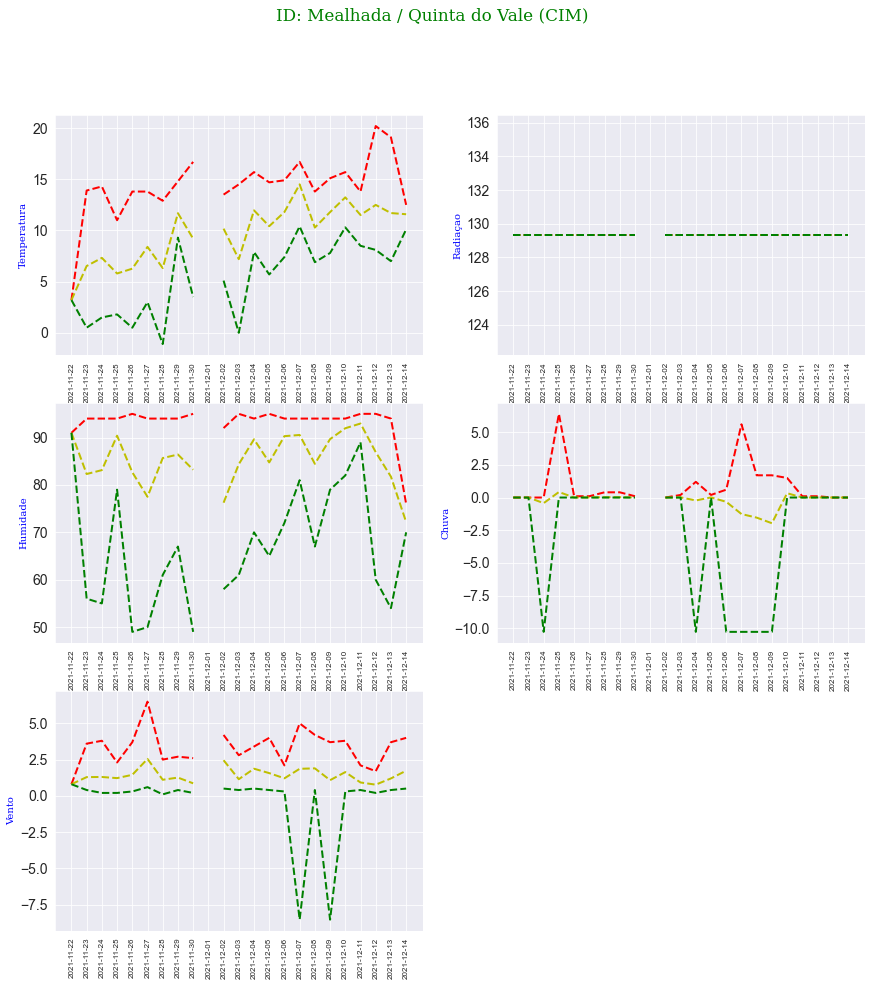

In [13]:
script=Scr_day('Topanga','Escolha a visualização pretendida','Dia','Todos os dias','3 dias','Stat')
script.iniciar('Search')

if script.event =='Submit':
    if script.values['cb1']==True:
        sg.popup('Exibir dia seleccionado')
        df_a=df_analise.copy()
        df_a['Data'], df_a['Hora']=df_a[feature_list[0]].str.split('T', 1).str
        plot_feat_st(df_a,DF_estation,station_name,dia_analise,'S')        
    if script.values['cb2']==True:
        sg.popup('Exibir todos os dias')
        station_name,feature_list,DF11,days=station_choice(estacao,DF1,feature_list,DF_estation)    
        plot_feat_st_1(DF11,DF_estation,station_name,'S')
    if script.values['cb3']==True:
        sg.popup('Exibirt ultimos 3 dias')
        station_name,feature_list,DF11,days=station_choice(estacao,DF1,feature_list,DF_estation)    
        plt_1_3d(DF11,DF_estation,dia_analise,estacao)
    if script.values['cb4']==True:
        sg.popup(' Maximas Médias Minimas')
        plot_medias(h,t,r,v,p,DF_estation,station)
    if script.values['cb1']!=True and script.values['cb2']!=True and script.values['cb3']!=True and script.values['cb4']!=True: 
        sg.popup('Nenhuma seleccao valida')
else:
    sg.popup('Cancelado')

# codigo de apoio

In [ ]:
measure_locals.valor


'1240610'

In [ ]:
measure_locals = IdStation(Stations_ID,DF_estation)
#measure_locals.cadastro()

measure_locals.get_by_index(12)
measure_locals.get_by_ID(1200502)
#measure_locals.get_by_index(20)
measure_locals.get_by_name('isb')
#measure_locals.get_by_X(script_label("coordenadas (X,Y)", 'introduza coordenada'))
#measure_locals.get_by_name(script_label("localidade", 'introduza a localidade'))